**Author:** Ngu (Nathan) Dang

# House Price Prediction - Advance Regression

## Overview

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

This Kaggle competition is a perfect practice for data science students who have completed an online course in machine learning and are looking to expand their skill set before trying a featured competition. 

## Table of Content

1. [Importing the Datasets](#section-1)
2. [EDA](#section-2)
3. [Feature Engineering](#section-3)
4. [Model Selection](#section-4)
5. [Model Development](#section-5)
6. [Evaluation & Final Submission](#section-6)
7. [Potential Improvements](#section-7)


# 0. Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import BayesianRidge, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


<a id="#section-1"> </a>
# 1. Importing the Datasets

## Files Description

Below is the description of each attached files in this project.

- train.csv - the training set
- test.csv - the test set
- data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [2]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# Check size and shape of datasets
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [5]:
# Train to test sets ratio
(df_test.shape[0]) / (df_train.shape[0] + df_test.shape[0])

0.499828708461802

<a id="#section-2"> </a>
# 2. EDA

In this section, we will perform some exploratory data analysis (EDA). Specifically, we will 

- examine the data type of each feature,
- detect and clean up NaN entries, 
- examine the correlation between features and remove highly correlated features if possible,
- examine the distribution, skewness, and outliers of the features and the target value,
- examine the correlation between the target value and some features

In [6]:
# Visualize the datatype on each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Train statistical summary
df_train.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


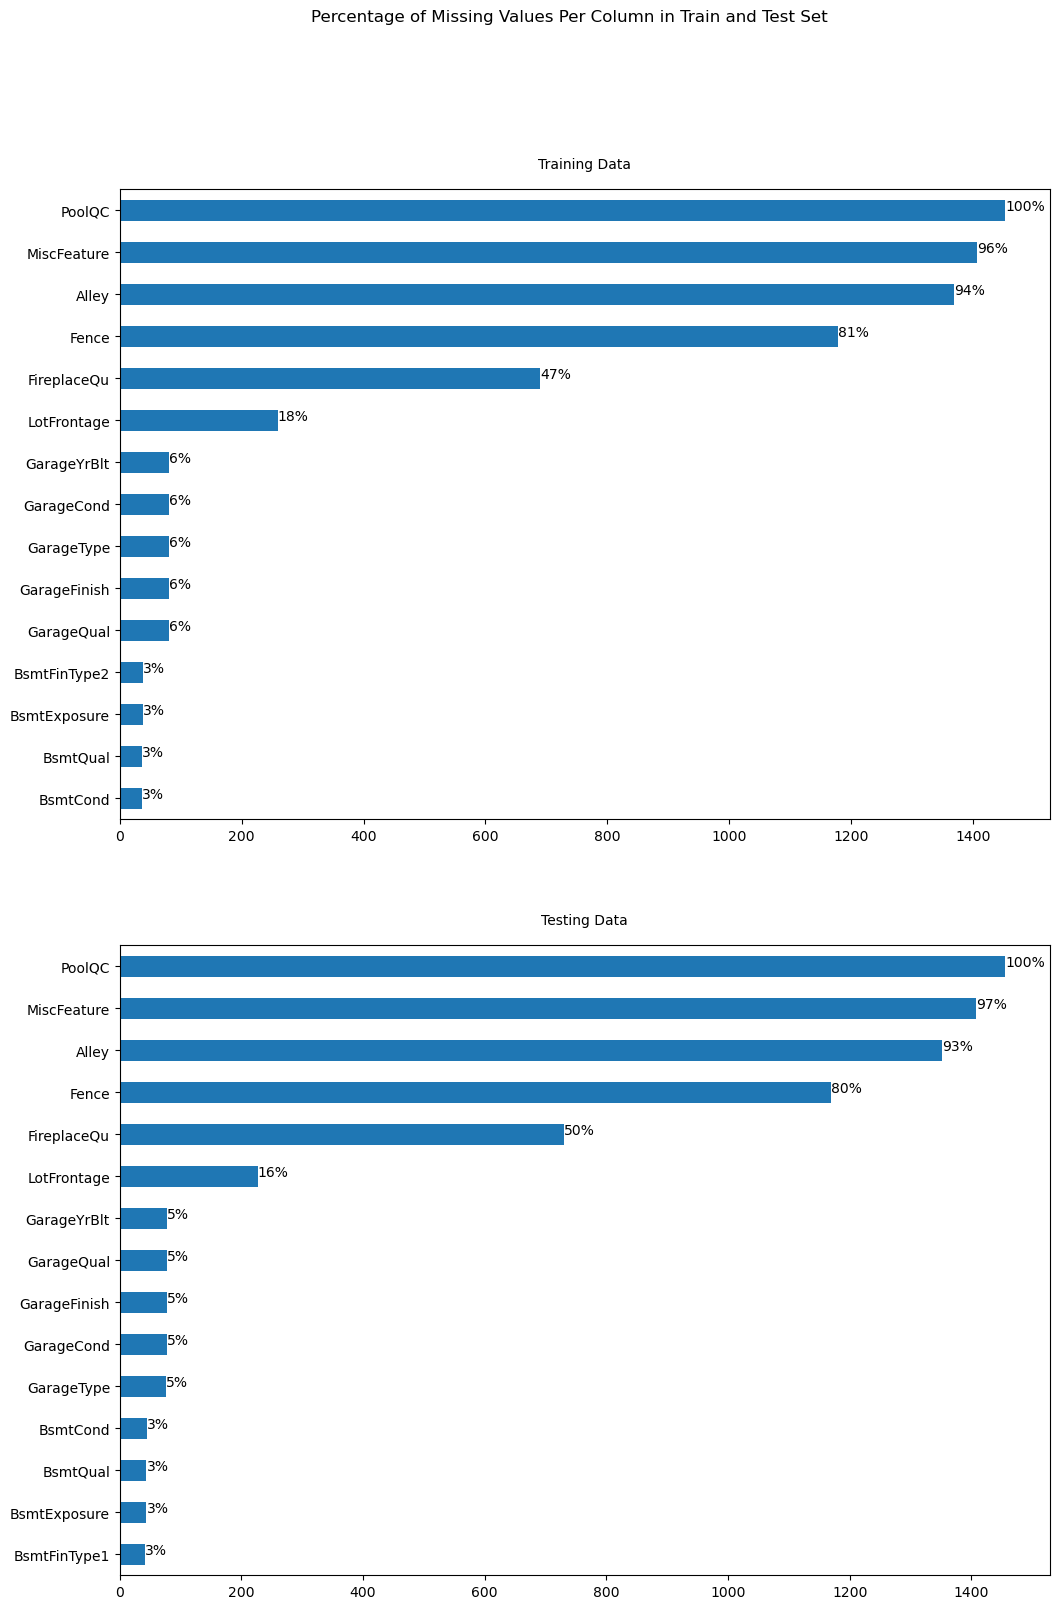

In [8]:
# Plot missing values in train and set
fig = plt.figure(figsize=(12, 18))

ax1 = fig.add_subplot(2, 1, 1)
ax1 = df_train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh')
for p in ax1.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/df_train.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax1.annotate(percentage,(x,y))
ax1.set_title('Training Data', y = 1.02, fontsize = 10)  
    
ax2 = fig.add_subplot(2, 1, 2)
ax2 = df_test.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh')
for p in ax2.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/df_test.shape[0])*100)
    width, height = p.get_width(),p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax2.annotate(percentage,(x,y))
ax2.set_title('Testing Data', y = 1.02, fontsize = 10)  
    
plt.suptitle('Percentage of Missing Values Per Column in Train and Test Set', fontdict={'size':25})
plt.show()

In [9]:
# clone the train and test sets
train_clean = df_train.copy()
test_clean = df_test.copy()

# Check for duplicate rows just in case
train_clean.duplicated().any(), test_clean.duplicated().any()

(False, False)

In [10]:
# drop the columns in both sets with more than 10% missing numerial values in the training data
threshold = 0.1 * train_clean.shape[0]
for i in train_clean.columns.to_list():
    if train_clean[i].isnull().sum() > threshold:
        train_clean.drop(i, axis=1, inplace=True)
        test_clean.drop(i, axis=1, inplace=True)

In [11]:
# Replace NaN with the average for each column that have less than 90% missing numerical values
train_clean.fillna(train_clean.mean(), inplace=True)
test_clean.fillna(test_clean.mean(), inplace=True)

In [12]:
# Replace NaN with the most frequent catergory for each column that have less than 90% missing categorical values
train_clean.apply(lambda x: x.fillna(x.value_counts().index[0], inplace=True))
test_clean.apply(lambda x: x.fillna(x.value_counts().index[0], inplace=True))

Id               None
MSSubClass       None
MSZoning         None
LotArea          None
Street           None
                 ... 
MiscVal          None
MoSold           None
YrSold           None
SaleType         None
SaleCondition    None
Length: 74, dtype: object

In [13]:
# Check for missing values to see if our code above works
train_clean.isnull().sum().any(), test_clean.isnull().sum().any()

(False, False)

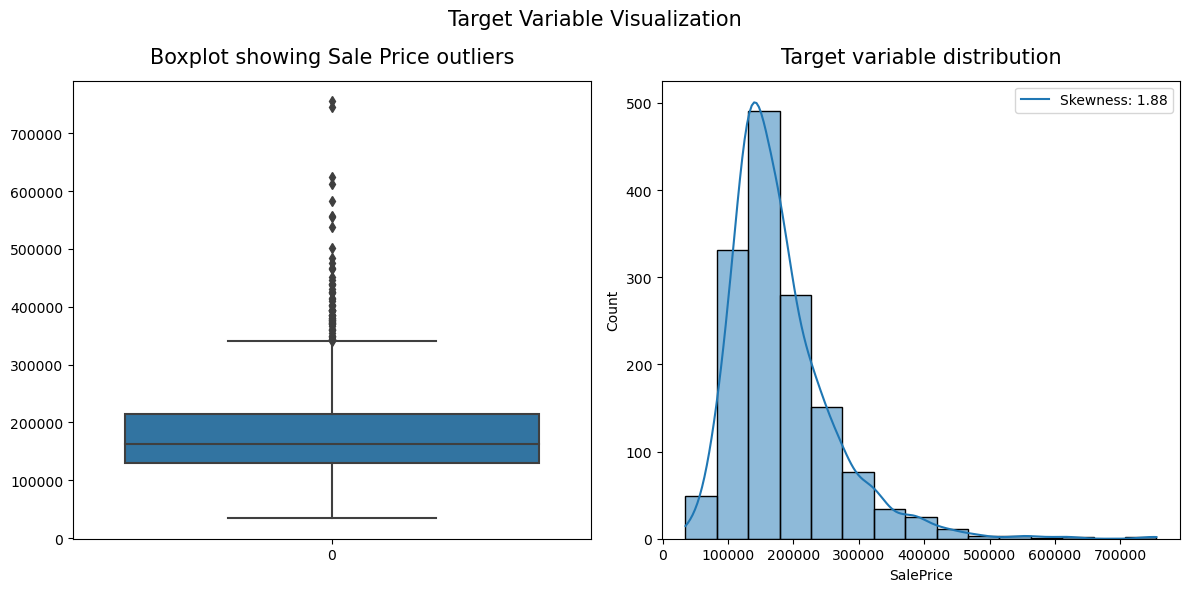

In [14]:
# Plot the distribution and outliers of the target value
fig = plt.figure(figsize=(12, 6))

# Plotting in first axes - boxplot for the Sale Price
axs1 = fig.add_subplot(1, 2, 1)
axs1.set_title('Boxplot showing Sale Price outliers', y = 1.02, fontsize = 15)
axs1 = sns.boxplot(train_clean['SalePrice'])

# Plotting in second axes - Sale Price Distribution
axs2 = fig.add_subplot(1, 2, 2)
axs2.set_title('Target variable distribution', y = 1.02, fontsize = 15)
axs2 = sns.histplot(train_clean['SalePrice'], kde = True, bins = 15)
axs2.legend(['Skewness: {:.2f}'.format(train_clean['SalePrice'].skew())])
            
#Adding a Title for the Overall Figure
fig.suptitle('Target Variable Visualization', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

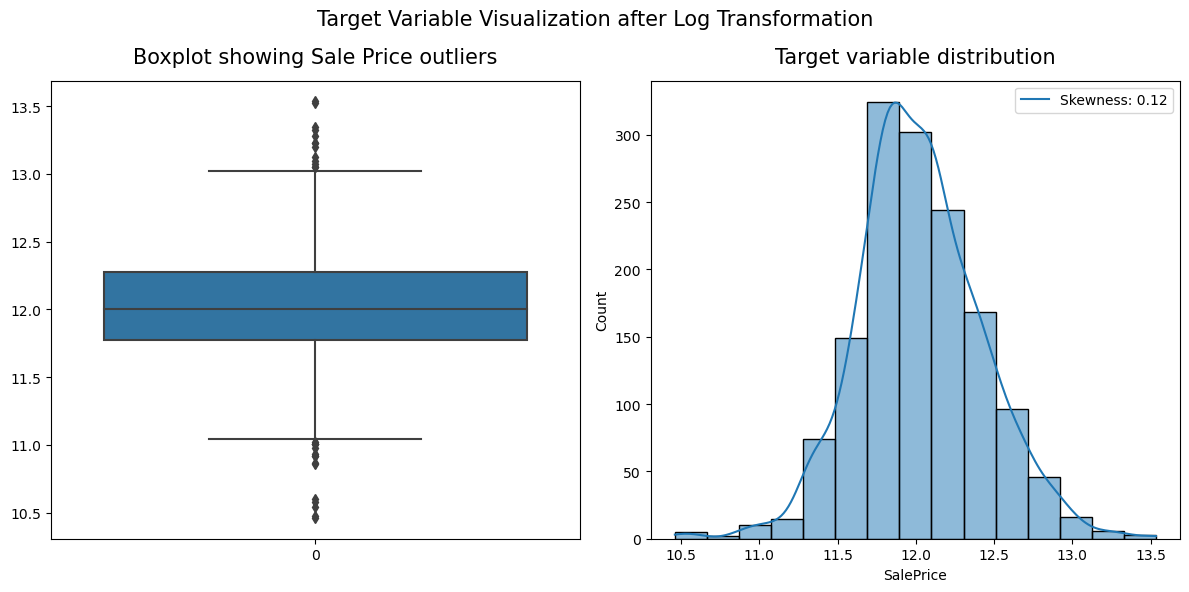

In [15]:
# Plot the distribution and outliers of the target value after log transformation
fig = plt.figure(figsize=(12, 6))

# Plotting in first axes - boxplot for the Sale Price
axs1 = fig.add_subplot(1, 2, 1)
axs1.set_title('Boxplot showing Sale Price outliers', y = 1.02, fontsize = 15)
axs1 = sns.boxplot(np.log(train_clean['SalePrice']))

# Plotting in second axes - Sale Price Distribution
axs2 = fig.add_subplot(1, 2, 2)
axs2.set_title('Target variable distribution', y = 1.02, fontsize = 15)
axs2 = sns.histplot(np.log(train_clean['SalePrice']), kde = True, bins = 15)
axs2.legend(['Skewness: {:.2f}'.format(np.log(train_clean['SalePrice']).skew())])
            
#Adding a Title for the Overall Figure
fig.suptitle('Target Variable Visualization after Log Transformation', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

In [16]:
# Top 20 correlated features to the target
top20_corrs = abs(train_clean.corr()['SalePrice']).sort_values(ascending = False).head(20)
top20_corrs

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.475241
GarageYrBlt     0.470177
Fireplaces      0.466929
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
Name: SalePrice, dtype: float64

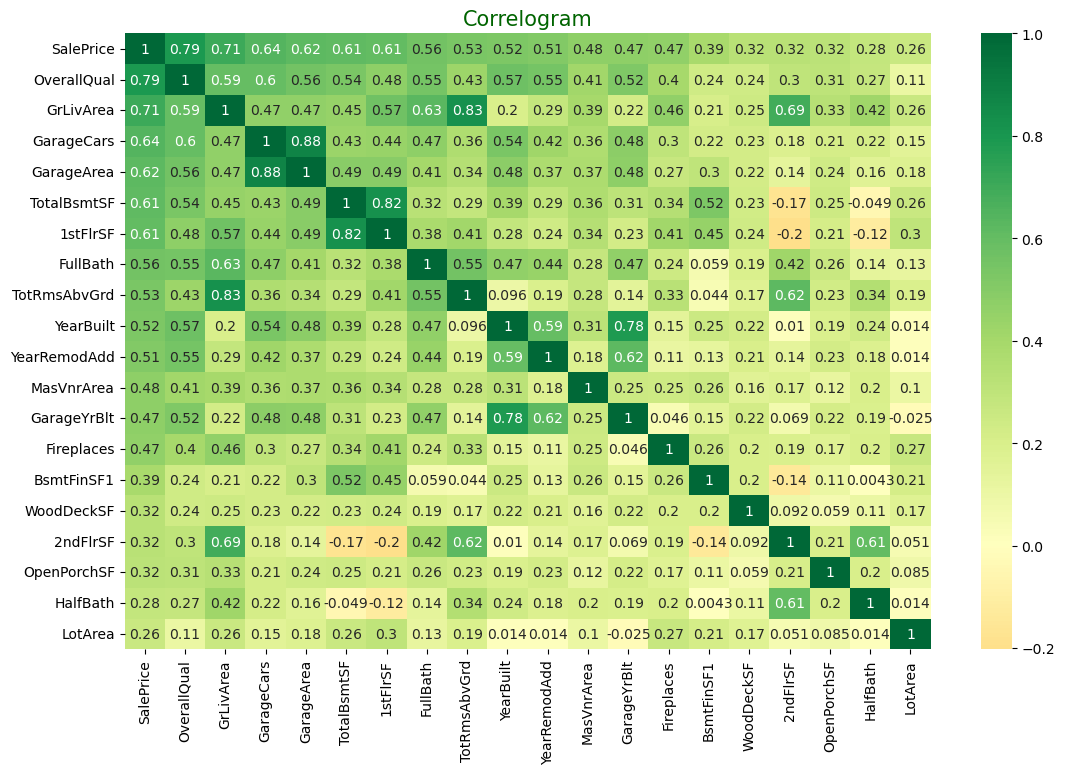

In [17]:
# Quantify correlations between features
corr = train_clean[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [18]:
# Filter out the features that are highly correlated
threshold = 0.8
train_clean_corr = train_clean.corr()
corr_upper = train_clean_corr.where(np.triu(np.ones(train_clean_corr.shape), k=1).astype(np.bool))
highly_correlated_features = [col for col in corr_upper.columns if any(corr_upper[col] > threshold)]
highly_correlated_features

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

In [19]:
# Drop the features found above
train_clean.drop(columns=highly_correlated_features, inplace=True)
test_clean.drop(columns=highly_correlated_features, inplace=True)

In [20]:
# Filter the numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_train_df = train_clean.select_dtypes(include=numerics)
numeric_features = numeric_train_df.columns.to_list()
numeric_features

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

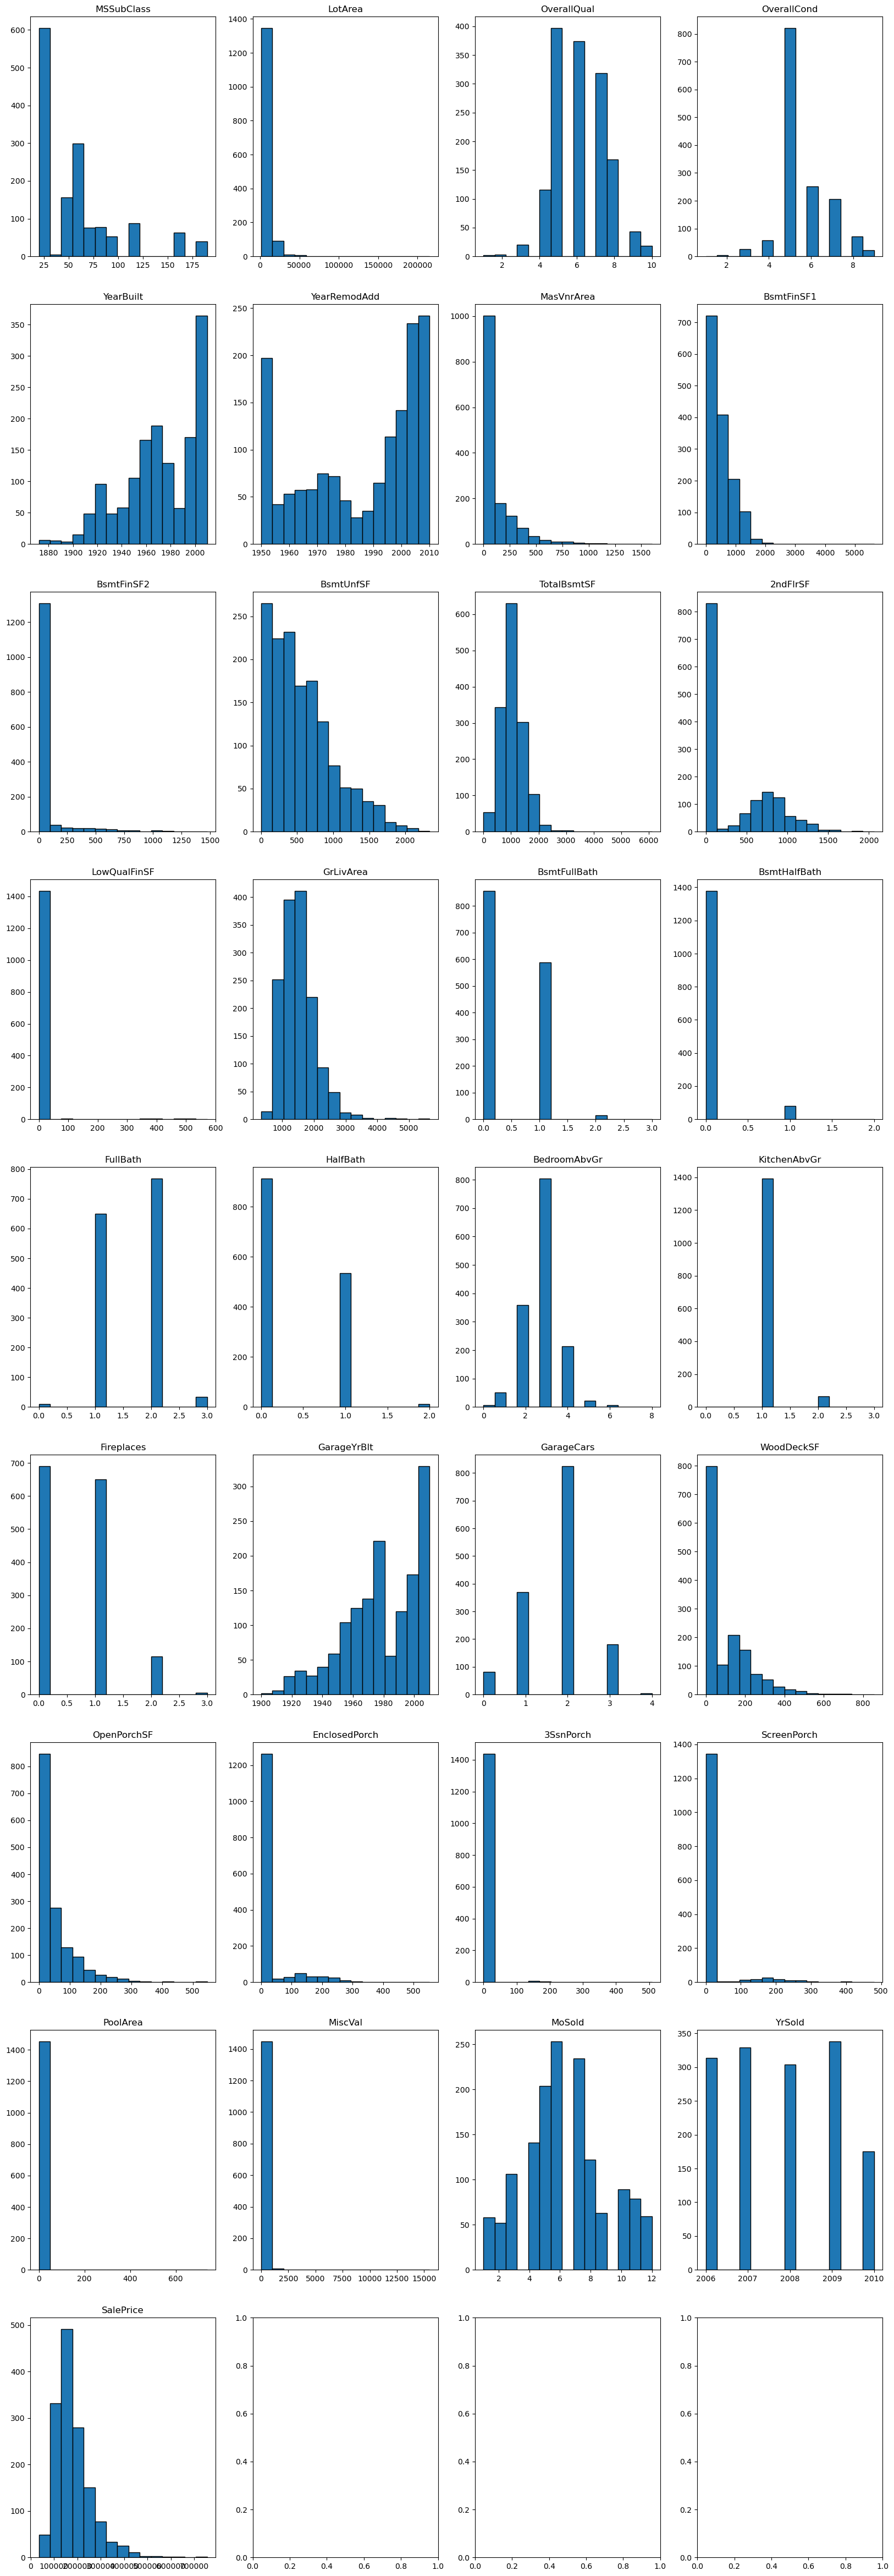

In [21]:
# Plot the distribution of the numeric features
f,ax = plt.subplots(9, 4, figsize=(20,60))
for i,ax in zip(numeric_features[1:], ax.reshape(-1)):
    ax.set_title(i)
    ax.hist(data=train_clean, x=i, edgecolor='black', bins=15)
plt.show()

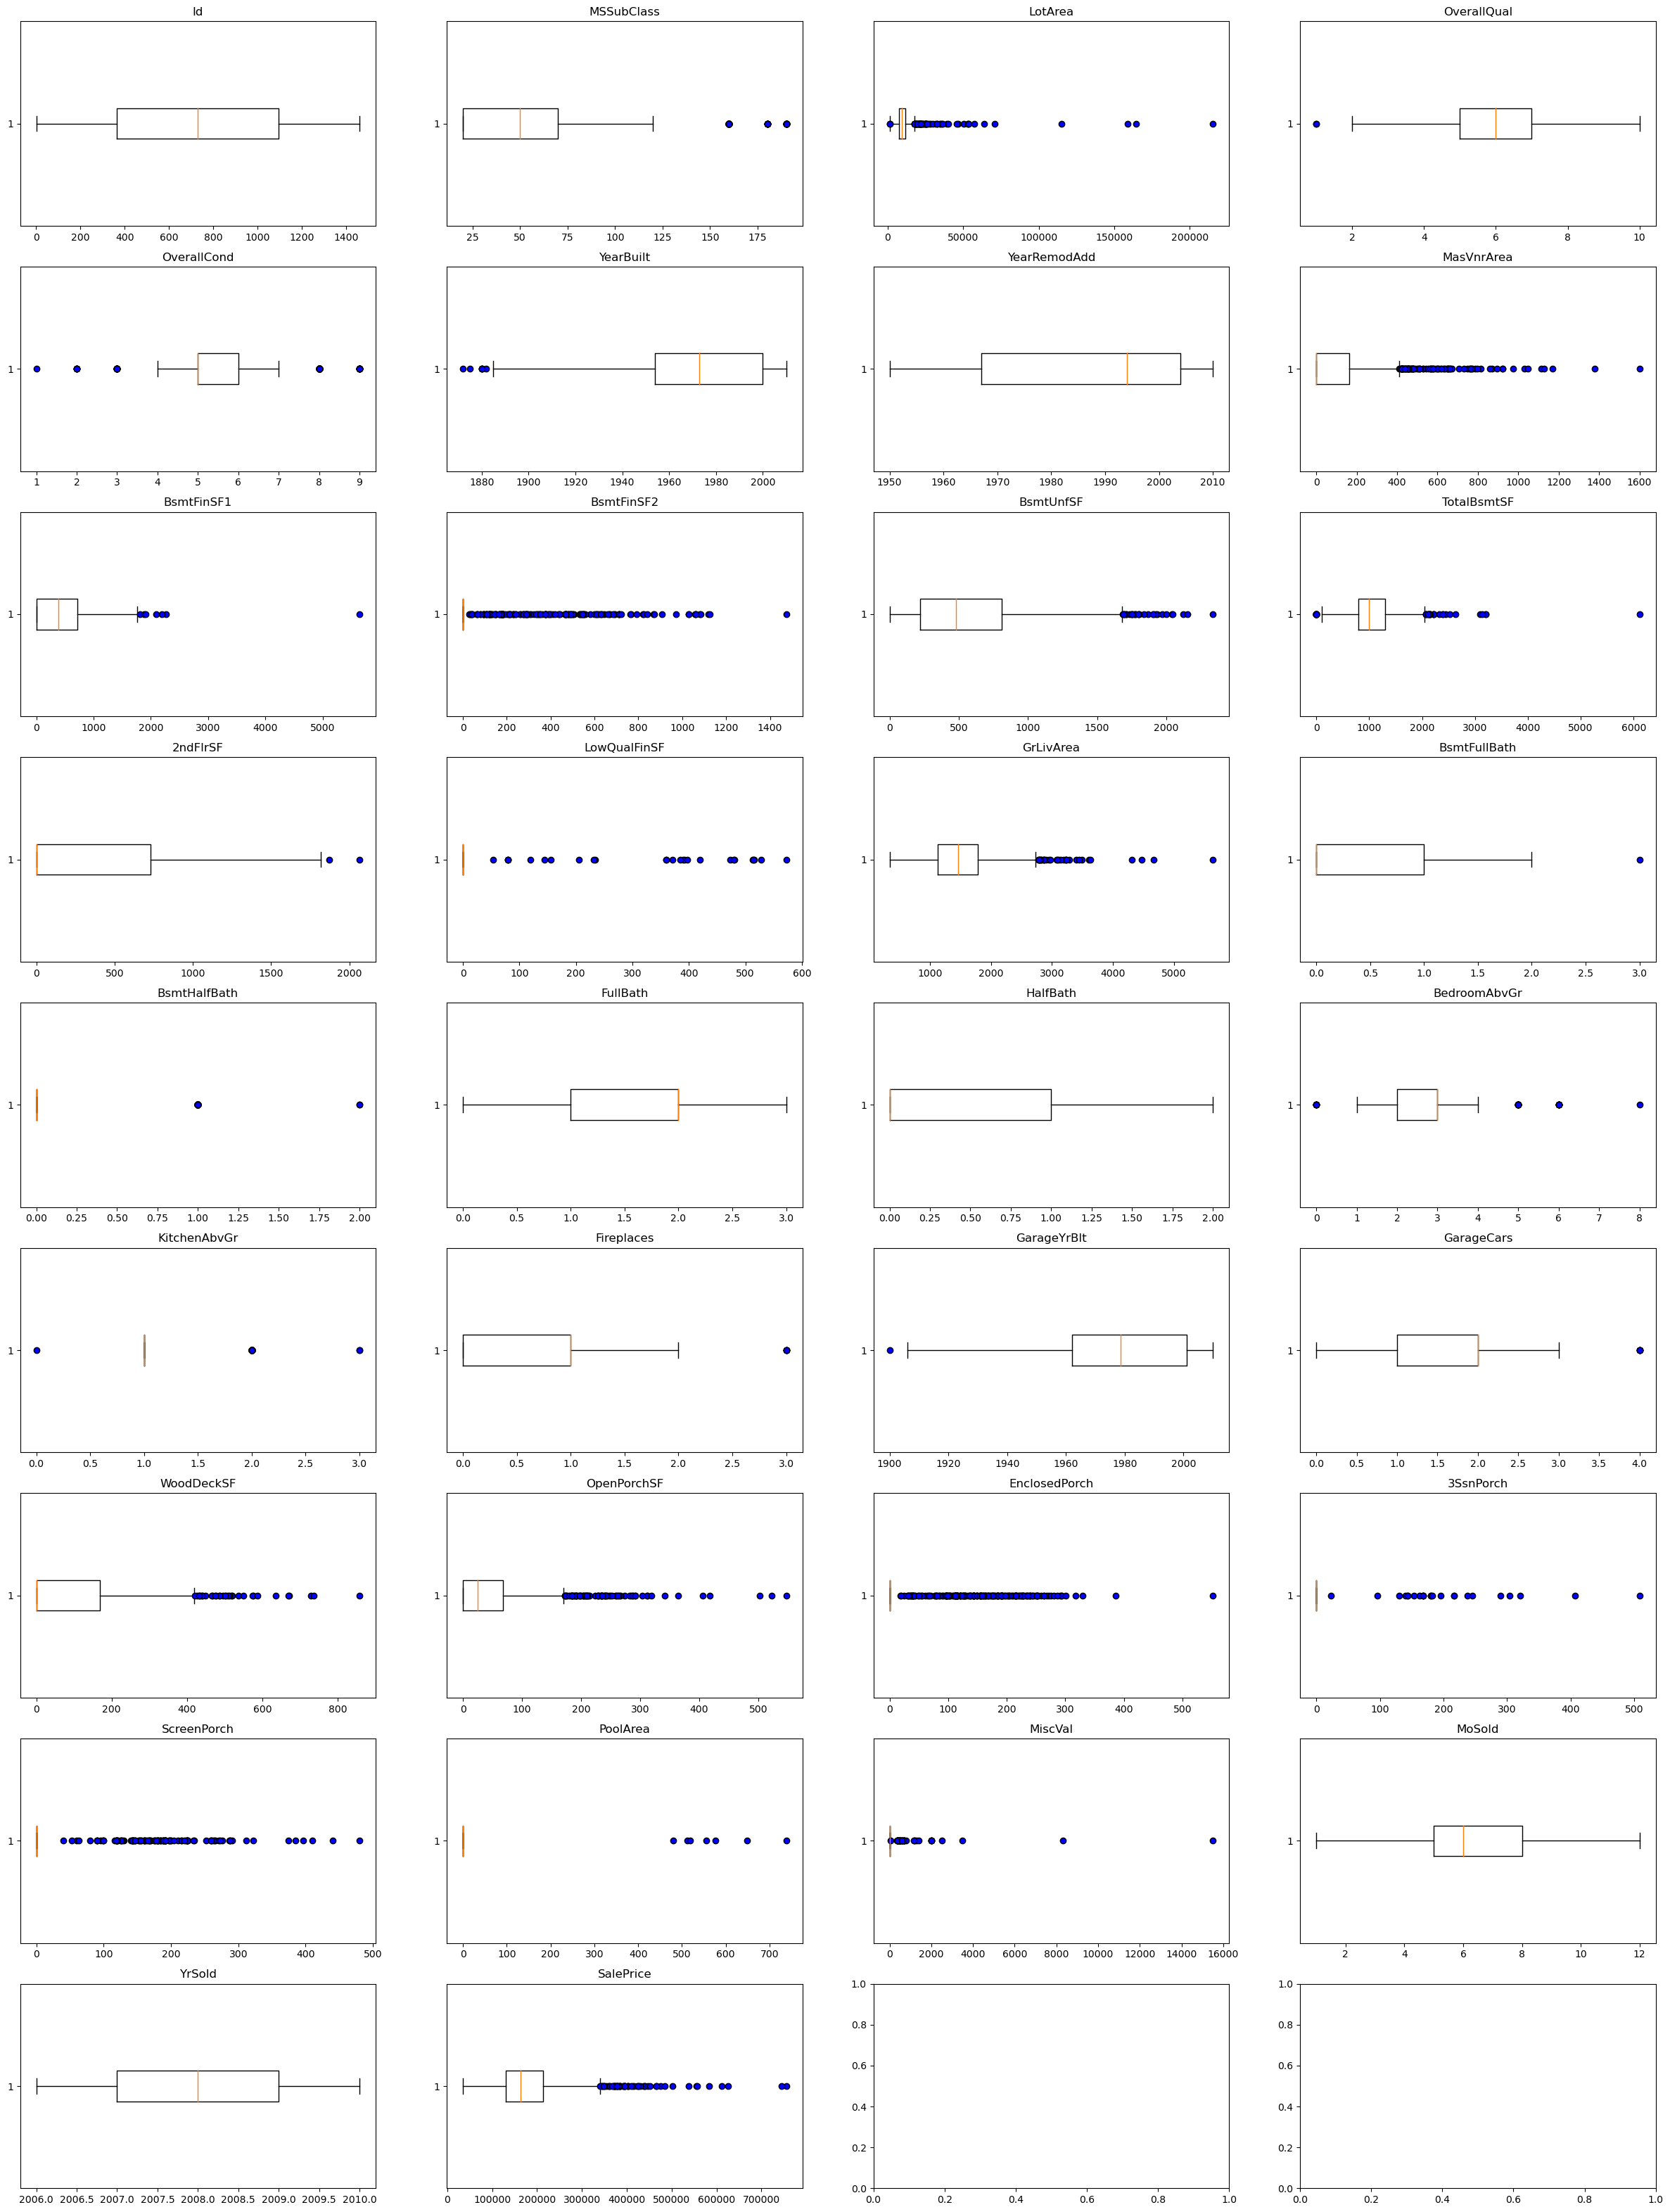

In [22]:
# Plot the statistics and outliers of the numerial features
f,ax = plt.subplots(9, 4, figsize=(30,40))
for i, ax in zip(numeric_features, ax.reshape(-1)):
    flierprops = dict(marker='o', markerfacecolor='blue', markeredgecolor='black', markersize=6)
    ax.boxplot(x = numeric_train_df[i], flierprops=flierprops, vert=False)
    ax.set_title(i)
plt.show()

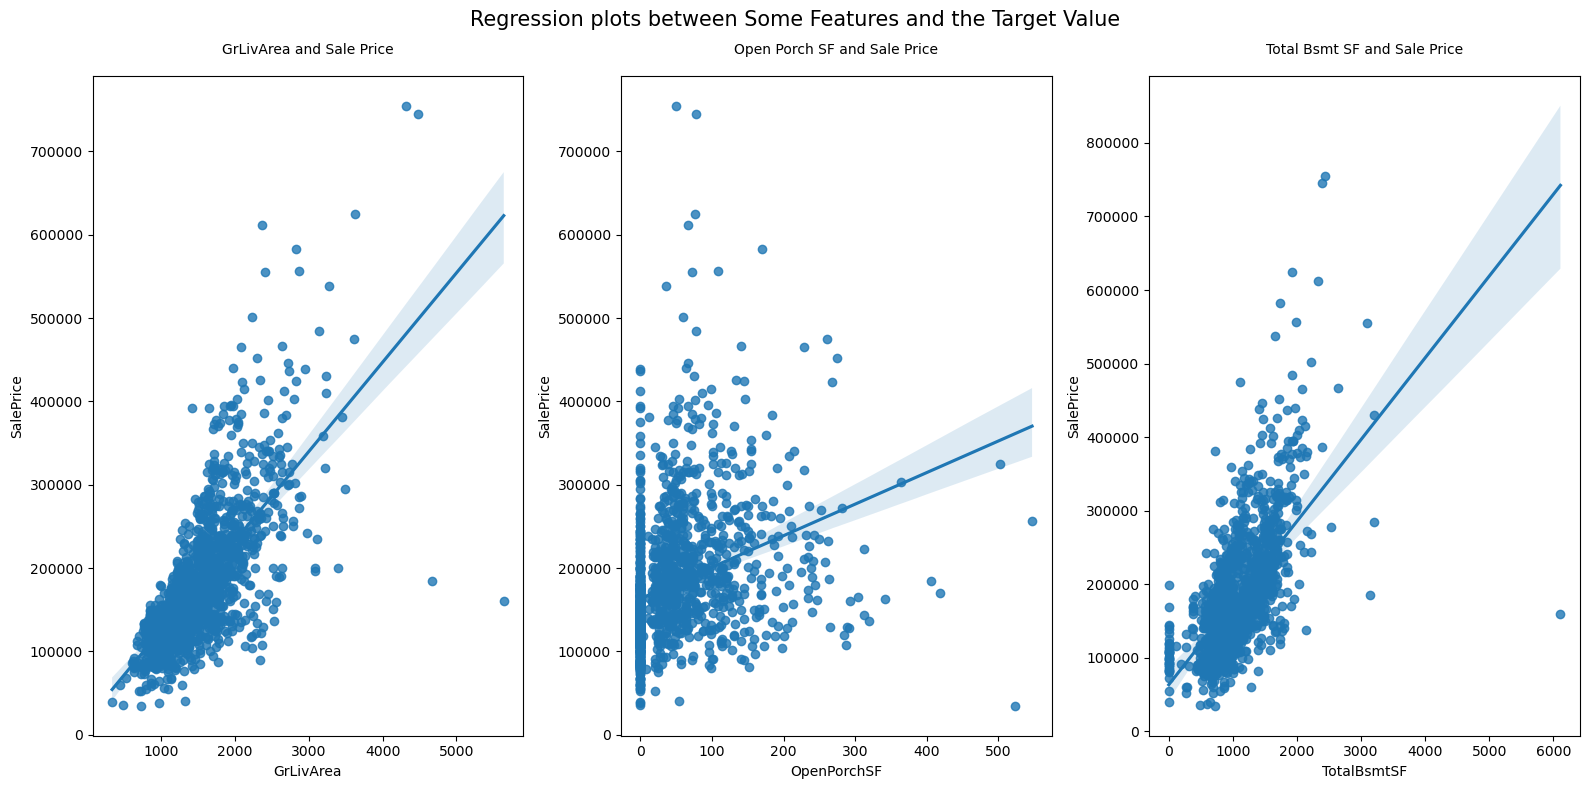

In [23]:
# Plot the regression between the target value and some features
fig = plt.figure(figsize=(16, 8))

# First axis
axs1 = fig.add_subplot(1, 3, 1)
axs1.set_title('GrLivArea and Sale Price', y = 1.02, fontsize = 10)
axs1 = sns.regplot(data=train_clean, x=train_clean['GrLivArea'], y=train_clean['SalePrice'])

# Second axis
axs2 = fig.add_subplot(1, 3, 2)
axs2.set_title('Open Porch SF and Sale Price', y = 1.02, fontsize = 10)
axs2 = sns.regplot(data=train_clean, x=train_clean['OpenPorchSF'], y=train_clean['SalePrice'])

# Third axis
axs3 = fig.add_subplot(1, 3, 3)
axs3.set_title('Total Bsmt SF and Sale Price', y = 1.02, fontsize = 10)
axs3 = sns.regplot(data=train_clean, x=train_clean['TotalBsmtSF'], y=train_clean['SalePrice'])
            
# Adding a Title for the Overall Figure
fig.suptitle('Regression plots between Some Features and the Target Value', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

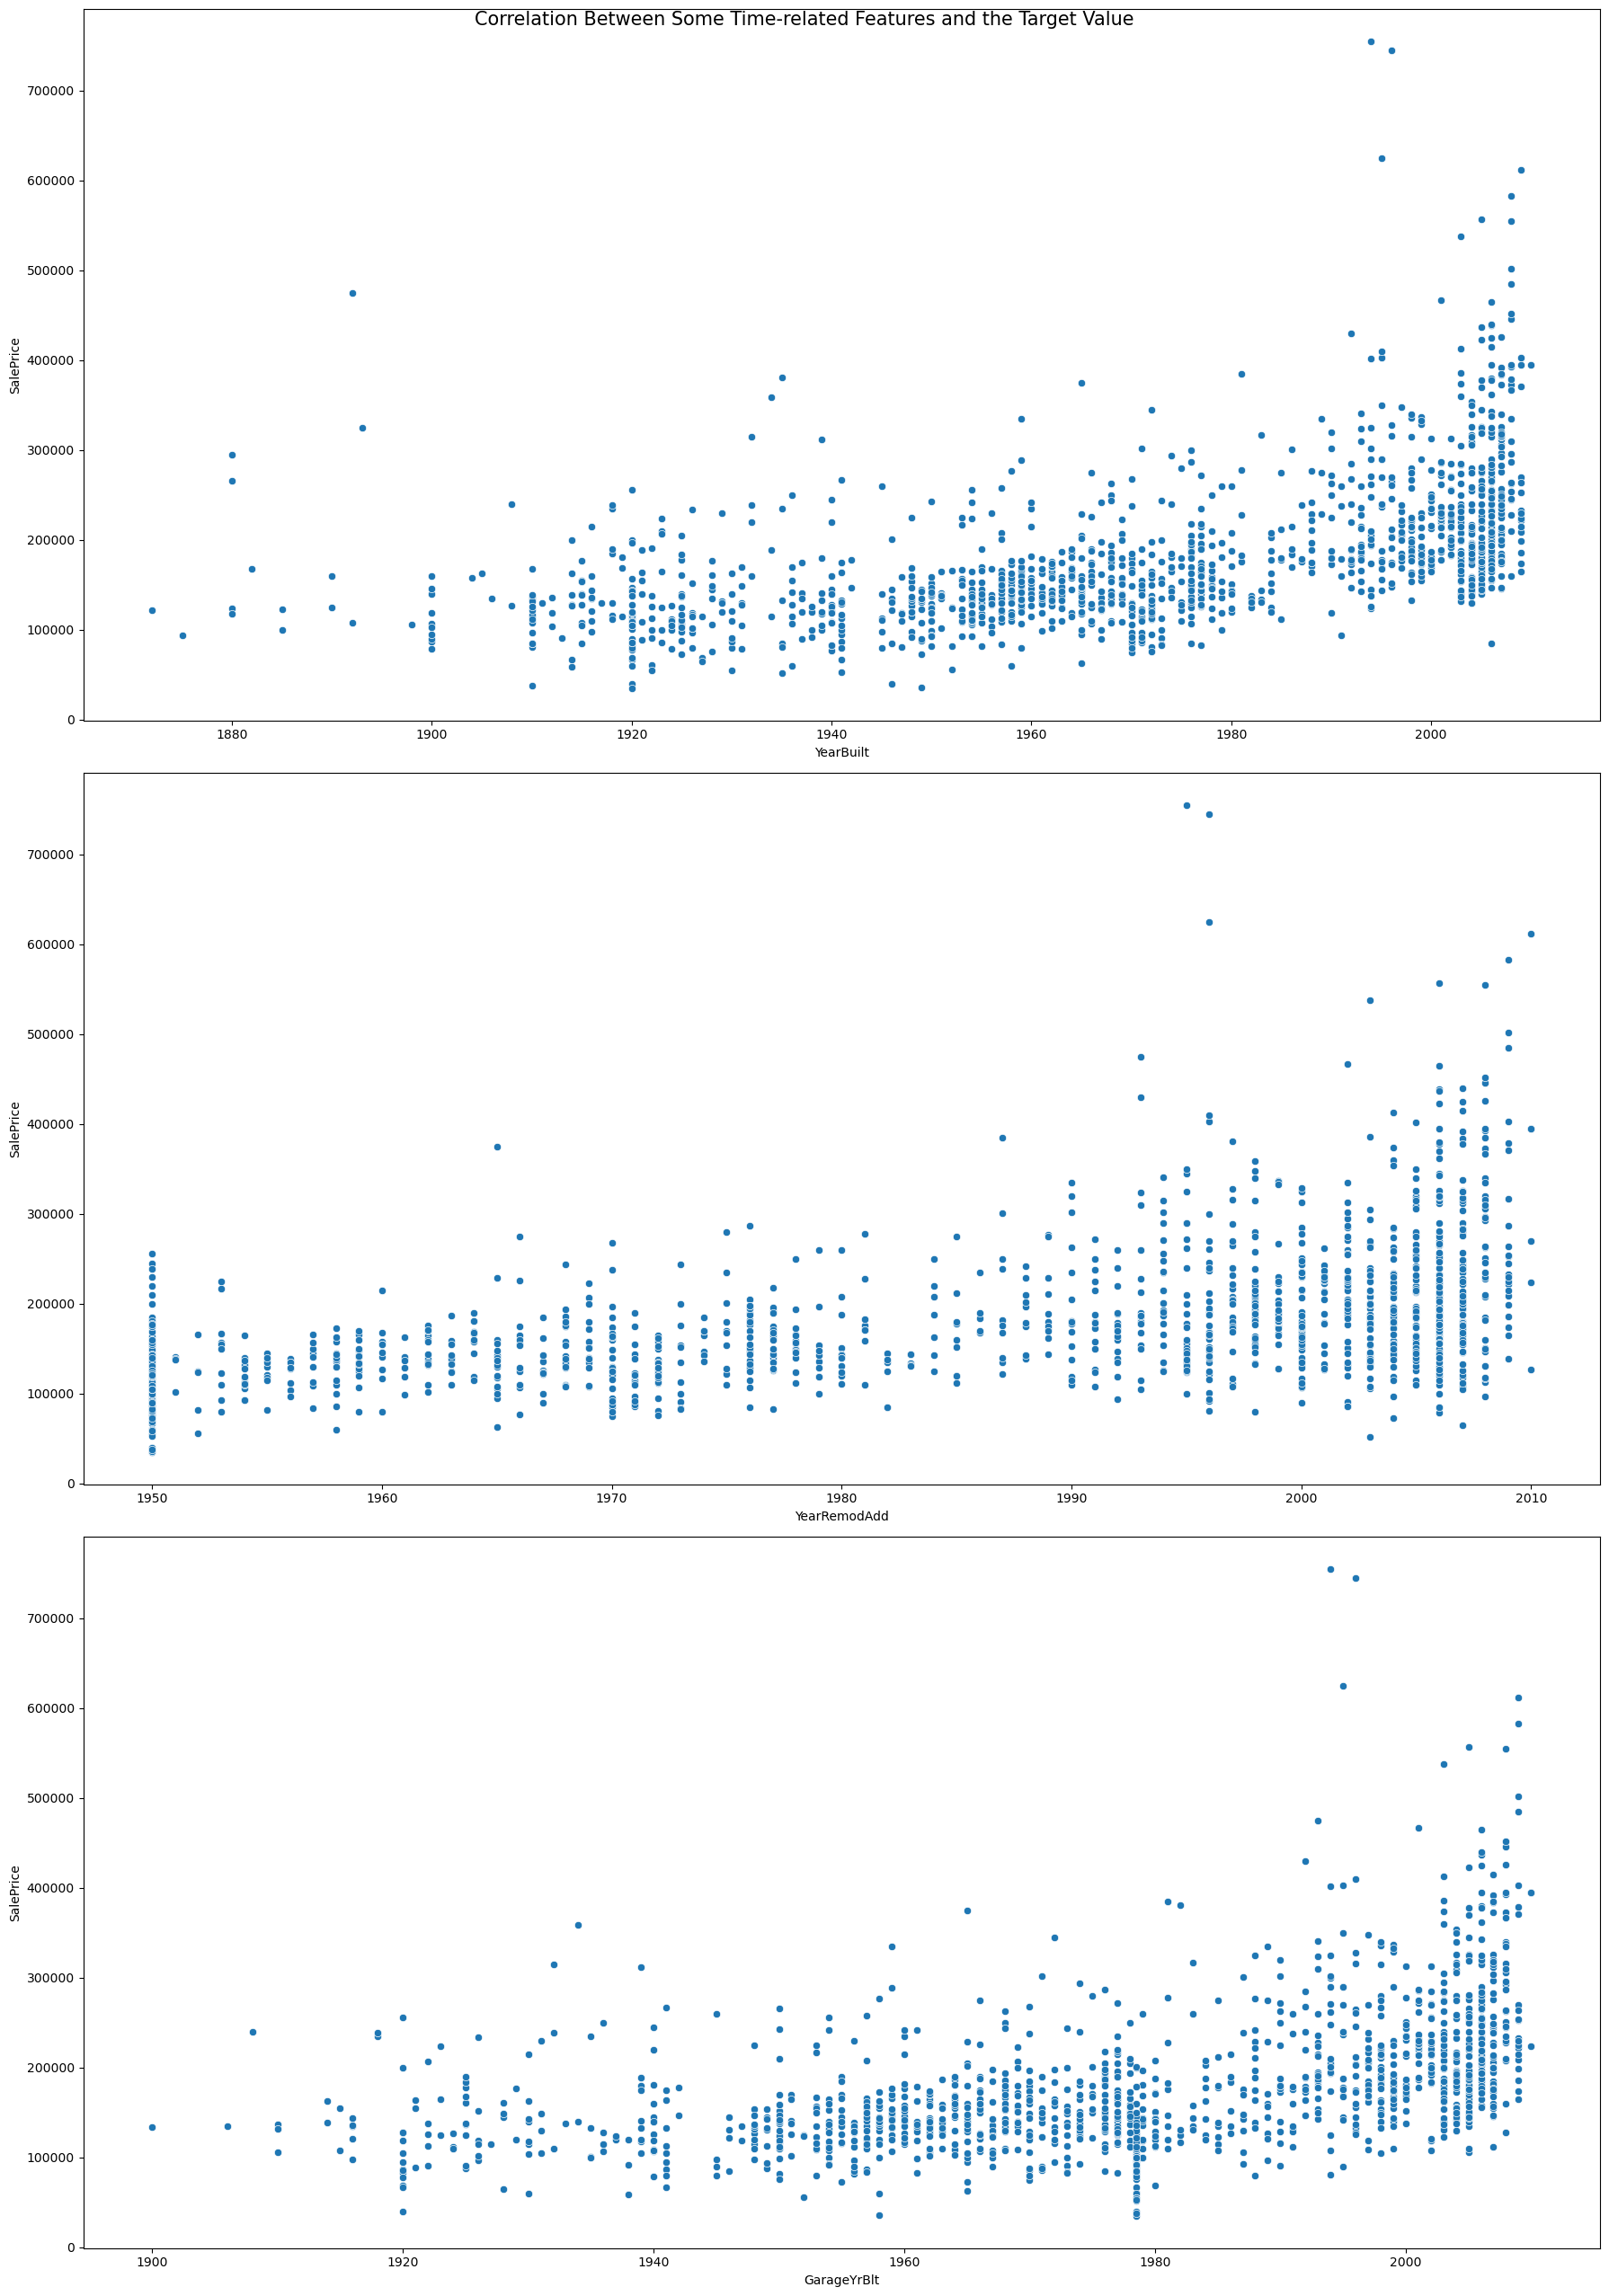

In [24]:
# Plot the Correlation between the Target Value and some Time-related Features
fig = plt.figure(figsize=(18, 26))

# First Axis
axs1 = fig.add_subplot(3, 1, 1)
axs1 = sns.scatterplot(data=train_clean, x="YearBuilt", y="SalePrice")

# Second Axis
axs2 = fig.add_subplot(3, 1, 2)
axs2 = sns.scatterplot(data=train_clean, x="YearRemodAdd", y="SalePrice")

# Thirds Axis
axs3 = fig.add_subplot(3, 1, 3)
axs3 = sns.scatterplot(data=train_clean, x="GarageYrBlt", y="SalePrice")

# Adding a Title for the Overall Figure
fig.suptitle('Correlation Between Some Time-related Features and the Target Value', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

<a id="#section-3"> </a>
# 3. Feature Engineering

In this section, we will perform some feature engineering. From the previous section, we can see that some time-related features correlate well with the target value, and thus making features that in the sense of whether the house is old or new can be helpful for our prediction. For example, a new house tends to be more expensive than an old one. 

Furthermore, we have a handful of categorial features in our data, so it might also be helpful to encode those features with some numerical values.

In [25]:
train_clean_eng = train_clean.copy()
test_clean_eng = test_clean.copy()

In [26]:
year_cols = [col for col in train_clean.columns if "Year" in col or "Yr" in col]
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [27]:
# helper method that compute the "age" garage or (remodeled) house
# the "age" is given by the sold year subtracted by the built/remodeled year
def add_age_features(df, year_cols):

    garage_age = df["YrSold"] - df["GarageYrBlt"]
    df["garageAge"] = np.max(garage_age) - garage_age + 1
    df["garageAge"] = df["garageAge"].fillna(0) # some houses have no garage --> 0 age

    house_age = df["YrSold"] - df["YearBuilt"]
    df["houseAge"] = np.max(house_age) - house_age + 1

    house_remodel = df["YrSold"] - df["YearRemodAdd"]
    df["houseRemodelAge"] = np.max(house_remodel) - house_remodel + 1

    return df.drop(columns=year_cols)

In [28]:
train_clean_eng = add_age_features(train_clean_eng, year_cols)
test_clean_eng = add_age_features(test_clean_eng, year_cols)

In [29]:
train_clean_eng.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,garageAge,houseAge,houseRemodelAge
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2,WD,Normal,208500,103.0,132,56
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,5,WD,Normal,181500,77.0,106,30
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,9,WD,Normal,223500,101.0,130,55
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,2,WD,Abnorml,140000,100.0,46,25
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,12,WD,Normal,250000,100.0,129,53


In [30]:
test_clean_eng.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,garageAge,houseAge,houseRemodelAge
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,0,0,6,WD,Normal,66.0,81,12
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,12500,6,WD,Normal,63.0,78,9
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,3,WD,Normal,102.0,117,49
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,6,WD,Normal,103.0,118,49
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,144,0,0,1,WD,Normal,97.0,112,43


In [31]:
# Filter out the categorical features
cat_cols = train_clean_eng.select_dtypes("object").columns
cat_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [32]:
# helper method that encodes categorical features with frequency of the category
def freq_encoding(df, cat_cols):
    
    for col in cat_cols:
        
        fe = df.groupby(col).size()
        fe_ = fe/len(df)
        df[col+"_fe"] = df[col].map(fe_)
    
    return df.drop(columns=cat_cols)

In [33]:
train_clean_eng = freq_encoding(train_clean_eng, cat_cols)
test_clean_eng = freq_encoding(test_clean_eng, cat_cols)

In [34]:
train_clean_eng.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Electrical_fe,KitchenQual_fe,Functional_fe,GarageType_fe,GarageFinish_fe,GarageQual_fe,GarageCond_fe,PavedDrive_fe,SaleType_fe,SaleCondition_fe
0,1,60,8450,7,5,196.0,706,0,150,856,...,0.914384,0.401370,0.931507,0.651370,0.289041,0.953425,0.963699,0.917808,0.867808,0.820548
1,2,20,9600,6,8,0.0,978,0,284,1262,...,0.914384,0.503425,0.931507,0.651370,0.289041,0.953425,0.963699,0.917808,0.867808,0.820548
2,3,60,11250,7,5,162.0,486,0,434,920,...,0.914384,0.401370,0.931507,0.651370,0.289041,0.953425,0.963699,0.917808,0.867808,0.820548
3,4,70,9550,7,5,0.0,216,0,540,756,...,0.914384,0.401370,0.931507,0.265068,0.469863,0.953425,0.963699,0.917808,0.867808,0.069178
4,5,60,14260,8,5,350.0,655,0,490,1145,...,0.914384,0.401370,0.931507,0.651370,0.289041,0.953425,0.963699,0.917808,0.867808,0.820548


In [35]:
test_clean_eng.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Electrical_fe,KitchenQual_fe,Functional_fe,GarageType_fe,GarageFinish_fe,GarageQual_fe,GarageCond_fe,PavedDrive_fe,SaleType_fe,SaleCondition_fe
0,1461,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,...,0.916381,0.519534,0.93146,0.636737,0.481837,0.939685,0.963674,0.891707,0.86292,0.825223
1,1462,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,...,0.916381,0.387252,0.93146,0.636737,0.481837,0.939685,0.963674,0.891707,0.86292,0.825223
2,1463,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,...,0.916381,0.519534,0.93146,0.636737,0.251542,0.939685,0.963674,0.891707,0.86292,0.825223
3,1464,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,...,0.916381,0.387252,0.93146,0.636737,0.251542,0.939685,0.963674,0.891707,0.86292,0.825223
4,1465,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,...,0.916381,0.387252,0.93146,0.636737,0.266621,0.939685,0.963674,0.891707,0.86292,0.825223


In [36]:
train_clean_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   MSSubClass        1460 non-null   int64  
 2   LotArea           1460 non-null   int64  
 3   OverallQual       1460 non-null   int64  
 4   OverallCond       1460 non-null   int64  
 5   MasVnrArea        1460 non-null   float64
 6   BsmtFinSF1        1460 non-null   int64  
 7   BsmtFinSF2        1460 non-null   int64  
 8   BsmtUnfSF         1460 non-null   int64  
 9   TotalBsmtSF       1460 non-null   int64  
 10  2ndFlrSF          1460 non-null   int64  
 11  LowQualFinSF      1460 non-null   int64  
 12  GrLivArea         1460 non-null   int64  
 13  BsmtFullBath      1460 non-null   int64  
 14  BsmtHalfBath      1460 non-null   int64  
 15  FullBath          1460 non-null   int64  
 16  HalfBath          1460 non-null   int64  


<a id="#section-4"> </a>
# 4. Model Selection

In this section, we will compare the performance of several commonly used regression models and pick the one with the best performance. The models for comparision are: Decision Tree Regressor, Random Forest Regressor, XGB Regressor, LGBM Regressor, and CatBoost Regressor.

From the EDA section, we can see that the distributions of the target value and some features are skewed, so it might be helpful to scale/transform them so that the distribution look closer to normal.

In [37]:
X = train_clean_eng.drop(columns=['SalePrice', 'Id'])
y = train_clean_eng['SalePrice']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
(X_train.shape, X_test.shape)

((1022, 69), (438, 69))

In [39]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [40]:
X_train_scaled = scaler.transform(X_train.astype(float))
X_test_scaled = scaler.transform(X_test.astype(float))

y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

In [41]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,...,Electrical_fe,KitchenQual_fe,Functional_fe,GarageType_fe,GarageFinish_fe,GarageQual_fe,GarageCond_fe,PavedDrive_fe,SaleType_fe,SaleCondition_fe
0,-0.868950,-0.030504,0.636031,0.392266,1.060186,-0.970484,-0.280335,1.643785,0.546130,-0.802294,...,0.303009,0.656399,0.283432,0.718305,1.051336,0.221974,0.199175,0.303047,0.379743,0.460493
1,2.882618,-0.624365,-0.823057,-0.508624,-0.146525,0.219303,-0.280335,-1.281383,-1.146608,-0.802294,...,0.303009,0.656399,0.283432,-2.208655,-1.174140,0.221974,0.199175,0.303047,0.379743,0.460493
2,0.068942,-0.185924,0.636031,-0.508624,-0.610644,-0.918281,-0.280335,0.360659,-0.679260,0.973582,...,0.303009,-0.149756,0.283432,0.718305,1.051336,0.221974,0.199175,0.303047,-2.851680,0.460493
3,-0.868950,0.081645,2.095118,-0.508624,1.141407,-0.970484,-0.280335,2.991965,1.890034,-0.802294,...,0.303009,-2.779228,0.283432,0.718305,-1.174140,0.221974,0.199175,0.303047,0.379743,0.460493
4,0.068942,-0.006927,0.636031,0.392266,-0.610644,-0.133065,1.995752,-1.124357,-0.583107,1.089252,...,0.303009,-0.149756,0.283432,0.718305,-0.707723,0.221974,0.199175,0.303047,-2.844016,0.460493


In [42]:
# helper method that computes the RMSE and R2 score on test data
def evaluate(model, test_features, test_labels):
    
    pred = model.predict(test_features)
    
    rmse = mean_squared_error(test_labels, pred, squared=False)
    r2 = r2_score(test_labels, pred)
    
    return [rmse, r2]

In [43]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train_scaled, y_train_scaled)

dt_reg_scores = evaluate(dt_reg, X_test_scaled, y_test_scaled)

print("For the Decision Tree Regressor model")
print("\tRMSE = ", dt_reg_scores[0])
print("\tR2 = ", dt_reg_scores[1])

For the Decision Tree Regressor model
	RMSE =  0.2026444190916426
	R2 =  0.7579387627743382


In [44]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_scaled, y_train_scaled)

rf_reg_scores = evaluate(rf_reg, X_test_scaled, y_test_scaled)

print("For the Random Forest Regressor model")
print("\tRMSE = ", rf_reg_scores[0])
print("\tR2 = ", rf_reg_scores[1])

For the Random Forest Regressor model
	RMSE =  0.1374922041525188
	R2 =  0.8885674415132921


In [45]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_scaled, y_train_scaled)

xgb_reg_scores = evaluate(xgb_reg, X_test_scaled, y_test_scaled)

print("For the XGB Regressor model")
print("\tRMSE = ", xgb_reg_scores[0])
print("\tR2 = ", xgb_reg_scores[1])

For the XGB Regressor model
	RMSE =  0.14672459906808535
	R2 =  0.8730999432113512


In [46]:
base_params = {
    
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mean_squared_error',
    'verbosity': -1
}

# Create the LightGBM model
lgbm_reg = lgb.LGBMRegressor(**base_params)
lgbm_reg.fit(X_train_scaled, y_train_scaled)

lgbm_reg_scores = evaluate(lgbm_reg, X_test_scaled, y_test_scaled)

print("For the LGBM Regressor model")
print("\tRMSE = ", lgbm_reg_scores[0])
print("\tR2 = ", lgbm_reg_scores[1])

For the LGBM Regressor model
	RMSE =  0.1319189001876219
	R2 =  0.8974182751060291


In [47]:
cb_reg = CatBoostRegressor(verbose=0)
cb_reg.fit(X_train_scaled, y_train_scaled)

cb_reg_scores = evaluate(cb_reg, X_test_scaled, y_test_scaled)

print("For the XGB Regressor model")
print("\tRMSE = ", cb_reg_scores[0])
print("\tR2 = ", cb_reg_scores[1])

For the XGB Regressor model
	RMSE =  0.12340629455172694
	R2 =  0.9102301337873233


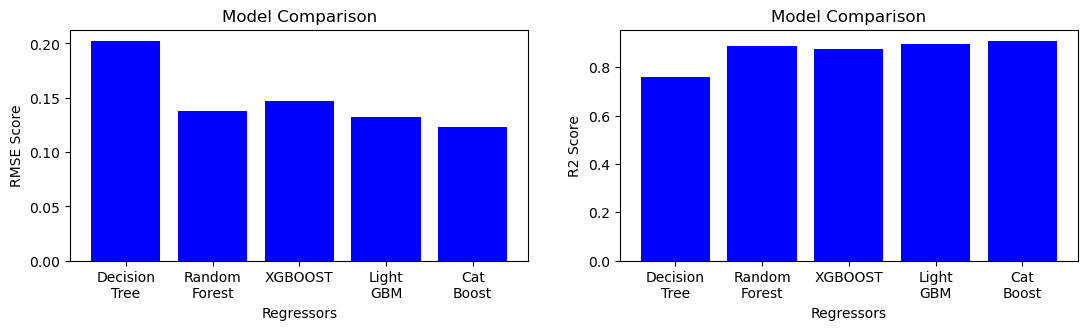

In [48]:
rmse_scores = [dt_reg_scores[0], rf_reg_scores[0], xgb_reg_scores[0], lgbm_reg_scores[0], cb_reg_scores[0]]
r2_scores = [dt_reg_scores[1], rf_reg_scores[1], xgb_reg_scores[1], lgbm_reg_scores[1], cb_reg_scores[1]]

fig = plt.figure(figsize=(13, 3))

axs1 = fig.add_subplot(1, 2, 1)
axs1.bar(['Decision\nTree','Random\nForest', 'XGBOOST', 'Light\nGBM', 'Cat\nBoost'],
             rmse_scores, color = 'blue')

axs1.set_ylabel('RMSE Score')
axs1.set_xlabel('Regressors')
axs1.set_title('Model Comparison')

axs2 = fig.add_subplot(1, 2, 2)
axs2.bar(['Decision\nTree','Random\nForest', 'XGBOOST', 'Light\nGBM', 'Cat\nBoost'],
             r2_scores, color = 'blue')

axs2.set_ylabel('R2 Score')
axs2.set_xlabel('Regressors')
axs2.set_title('Model Comparison')

plt.show()

<a id="#section-5"> </a>
# 5. Model Development

In this section, we will fine tune the parameters of the chosen model based on the comparison above, i.e. CatBoost Regression.

In [49]:
parameters = {'depth'         : [6, 8, 10, 12],
              'learning_rate' : [0.01, 0.05, 0.1, 1],
              'iterations'    : [25, 50, 100, 200]
             }

model_CBR = CatBoostRegressor(verbose=0)

In [50]:
grid_search_cb = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 10, n_jobs=-1, verbose=1)
grid_search_cb.fit(X_train_scaled, y_train_scaled)

grid_search_cb.best_params_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

In [51]:
best_grid_search = grid_search_cb.best_estimator_
grid_search_scores = evaluate(best_grid_search, X_test_scaled, y_test_scaled)

print("For the model from grid search")
print("\tRMSE = ", grid_search_scores[0])
print("\tR2 = ", grid_search_scores[1])

For the model from grid search
	RMSE =  0.12239713000758745
	R2 =  0.9116923307129207


<a id="#section-6"> </a>
# 6. Evaluation & Final Submission

In this section, we will build the final model for submission. We use the best parameters found in the section above and train the model on the full given training data. Recall that our model predicts the log of the actual values, so we need to take the exponent of the predicted values to obtain the actual ones.

In [52]:
X_test_final = test_clean_eng.drop(columns=['Id'])

In [53]:
X_test_final.head()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,...,Electrical_fe,KitchenQual_fe,Functional_fe,GarageType_fe,GarageFinish_fe,GarageQual_fe,GarageCond_fe,PavedDrive_fe,SaleType_fe,SaleCondition_fe
0,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,0,...,0.916381,0.519534,0.93146,0.636737,0.481837,0.939685,0.963674,0.891707,0.86292,0.825223
1,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,0,...,0.916381,0.387252,0.93146,0.636737,0.481837,0.939685,0.963674,0.891707,0.86292,0.825223
2,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,701,...,0.916381,0.519534,0.93146,0.636737,0.251542,0.939685,0.963674,0.891707,0.86292,0.825223
3,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,678,...,0.916381,0.387252,0.93146,0.636737,0.251542,0.939685,0.963674,0.891707,0.86292,0.825223
4,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,0,...,0.916381,0.387252,0.93146,0.636737,0.266621,0.939685,0.963674,0.891707,0.86292,0.825223


In [55]:
# scale the data
scaler_final = StandardScaler()
scaler_final.fit(X)

X_scaled = scaler_final.transform(X)
X_test_final_scaled = scaler_final.transform(X_test_final)

y_scaled = np.log(y)

In [56]:
# build the final model based on best parameters found previously
_depth = 6
_learning_rate = 0.1
_iterations = 200

model_CBR_final = CatBoostRegressor(iterations = _iterations, 
                                    learning_rate = _learning_rate, 
                                    depth = _depth, verbose=0)

model_CBR_final.fit(X_scaled, y_scaled)

In [57]:
y_sub_pred = model_CBR_final.predict(X_test_final_scaled)
np.exp(y_sub_pred)

array([ 95544.54509951, 160544.75100833, 178658.97823443, ...,
       166159.90024321, 115279.25467085, 233688.27487641])

In [58]:
# Create the submission file
# Recall that our model predicts the log of the target values
# So we need to take the exponent of the predicted values to obtain actual ones

submission = pd.DataFrame({'Id': test_clean_eng['Id'], 'SalePrice': np.exp(y_sub_pred)})

submission.head()

,Id,SalePrice
0,1461,95544.545100
1,1462,160544.751008
2,1463,178658.978234
3,1464,180756.793354
4,1465,186493.599036


In [59]:
# Save the submission file to working folder
submission.to_csv('submission.csv', index = False)

<a id="#section-7"> </a>
# 7. Potential Improvements

From the result of the best recent submission, the obtained RMSE score was 0.1303 which claimed the top 25% on the leaderboard

Some potential improvements for this work can be

- It appears that there are some anomalies in the data which can be handled so that the data can be cleaner.
- There could be a better way to encode the categorical data.
- The current work does not consider the skewness of features, it only took care of the skewness of the target value.
- Perhaps Randomized Grid Search can be used to cover a better grid of parameters (with better ranges of params) and then narrow it down with Deterministic Grid Search. Or we can apply Optuna for fine tuning the parameters of CatBoost Regression Model as shown [here](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/)
